In [1]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📥 Load Sentiment Dataset
sentiment_data = pd.read_csv("/content/all-data.csv", header=None, encoding='ISO-8859-1')
sentiment_data.columns = ['sentiment', 'headline']
sentiment_data['sentiment_score'] = sentiment_data['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
sentiment_data['date'] = pd.date_range(start='2014-01-02', periods=len(sentiment_data), freq='B')
daily_sentiment = sentiment_data.groupby('date')['sentiment_score'].mean().reset_index()

# 📈 Load and Process AAPL Stock Data
df = pd.read_csv("/content/SP 500 Stock Prices 2014-2017 2.csv")
df = df[df['symbol'] == 'AAPL'].copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 📊 Feature Engineering
df['daily_return'] = df['close'] - df['open']
df['price_range'] = df['high'] - df['low']
df['avg_price'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df['rolling_std'] = df['close'].rolling(5).std()
df['percent_change'] = df['close'].pct_change()
df['ma_3'] = df['close'].rolling(3).mean()
df['ma_7'] = df['close'].rolling(7).mean()
df['ma_14'] = df['close'].rolling(14).mean()
df['ma_ratio'] = df['ma_3'] / df['ma_7']
df['vol_change'] = df['volume'].pct_change()
df['close_lag_1'] = df['close'].shift(1)
df['volume_lag_1'] = df['volume'].shift(1)
df = df.dropna()

# 🔗 Merge with Sentiment Data
merged_df = pd.merge(df, daily_sentiment, on='date', how='left')
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)
merged_df['sentiment_ma3'] = merged_df['sentiment_score'].rolling(3).mean()
merged_df['sentiment_ma5'] = merged_df['sentiment_score'].rolling(5).mean()
merged_df = merged_df.fillna(0).reset_index(drop=True)

# 🎯 Create 3-Day Trend Target
merged_df['trend_3day'] = (
    (merged_df['close'].shift(-1) < merged_df['close'].shift(-2)) &
    (merged_df['close'].shift(-2) < merged_df['close'].shift(-3))
).astype(int)
merged_df = merged_df[:-3]  # remove last 3 rows with no label

# 📐 Feature Set
features = ['open', 'high', 'low', 'close', 'volume', 'daily_return',
            'price_range', 'avg_price', 'rolling_std', 'percent_change',
            'ma_3', 'ma_7', 'ma_14', 'ma_ratio', 'vol_change',
            'close_lag_1', 'volume_lag_1', 'sentiment_score', 'sentiment_ma3', 'sentiment_ma5']

# 🔄 Normalize Features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(merged_df[features])
labels = merged_df['trend_3day'].values

# 🔁 Create LSTM Sequences
def create_sequences(data, labels, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(labels[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, labels, window_size=30)

# ✂️ Train/Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [2]:
# 🧠 Model Architecture
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(64),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 🧪 Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🛑 Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# 🚀 Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.6748 - loss: 0.6005 - val_accuracy: 0.6364 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7055 - loss: 0.5926 - val_accuracy: 0.6364 - val_loss: 0.6558 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7504 - loss: 0.5628 - val_accuracy: 0.6364 - val_loss: 0.6526 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.7245 - loss: 0.6021 - val_accuracy: 0.6364 - val_loss: 0.6544 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7342 - loss: 0.5643 - val_accuracy: 0.6364 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.7676 - loss: 0.5348 - val_accuracy: 0.6364 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7421 - loss: 0.5771 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step
✅ Accuracy: 73.58%
📋 Classification Report:
               precision    recall  f1-score   support

        Down       0.74      1.00      0.85       142
          Up       0.00      0.00      0.00        51

    accuracy                           0.74       193
   macro avg       0.37      0.50      0.42       193
weighted avg       0.54      0.74      0.62       193



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


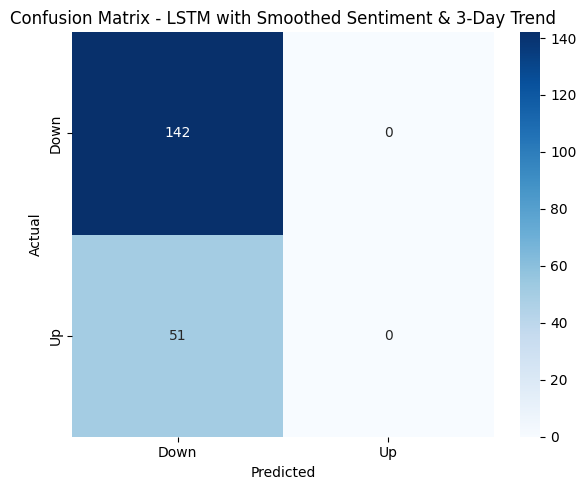

In [3]:
# 🎯 Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 📊 Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Down", "Up"])
cm = confusion_matrix(y_test, y_pred)

print(f"✅ Accuracy: {acc * 100:.2f}%")
print("📋 Classification Report:\n", report)

# 🔍 Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix - LSTM with Smoothed Sentiment & 3-Day Trend")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()